In [1]:
import os
import time
import random
import itertools
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import NASNetLarge, MobileNetV2, InceptionV3, EfficientNetB4, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#--------------------------------------------------------------------------------------#

print(f'Tensorflow Version: {tf.__version__}')

print("GPU Available:", tf.config.list_physical_devices('GPU')[0])

#--------------------------------------------------------------------------------------#

import warnings

warnings.filterwarnings("ignore")

Tensorflow Version: 2.17.1
GPU Available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
# helper functions

#--------------------------------------------------------------------------------------#

def data_appender(data, path, folder):
    folderpath = os.path.join(path, folder)
    files = os.listdir(folderpath)
    
    for file in files:
        filepath = os.path.join(folderpath, file)
        data['imgpath'].append(filepath)
        data['labels'].append(folder)
    
    return data

In [3]:
data = {'imgpath': [], 'labels': []}
path = '/kaggle/input/gamblingsitesid-img2/gamblingsitesid'
folders = [
    'judi_resized',
    'non-judi_resized',
]

for folder in folders:
    data = data_appender(data = data, path = path, folder = folder)

dataset = pd.DataFrame(data)
dataset.head()

,imgpath,labels
0,/kaggle/input/gamblingsitesid-img2/gamblingsit...,judi_resized
1,/kaggle/input/gamblingsitesid-img2/gamblingsit...,judi_resized
2,/kaggle/input/gamblingsitesid-img2/gamblingsit...,judi_resized
3,/kaggle/input/gamblingsitesid-img2/gamblingsit...,judi_resized
4,/kaggle/input/gamblingsitesid-img2/gamblingsit...,judi_resized


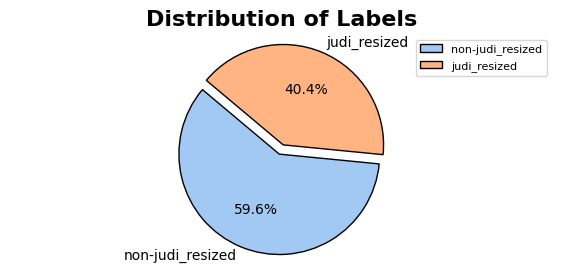

In [4]:
# Count the number of occurrences of each label
label_counts = dataset['labels'].value_counts()

# Plotting
plt.figure(figsize=(7, 3))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140,
        colors=sns.color_palette('pastel'), explode=[0.1] + [0] * (len(label_counts) - 1),
        wedgeprops=dict(edgecolor='black'))

plt.title('Distribution of Labels', fontsize=16, fontweight='bold')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(label_counts.index, loc="best", fontsize=8)
plt.show()

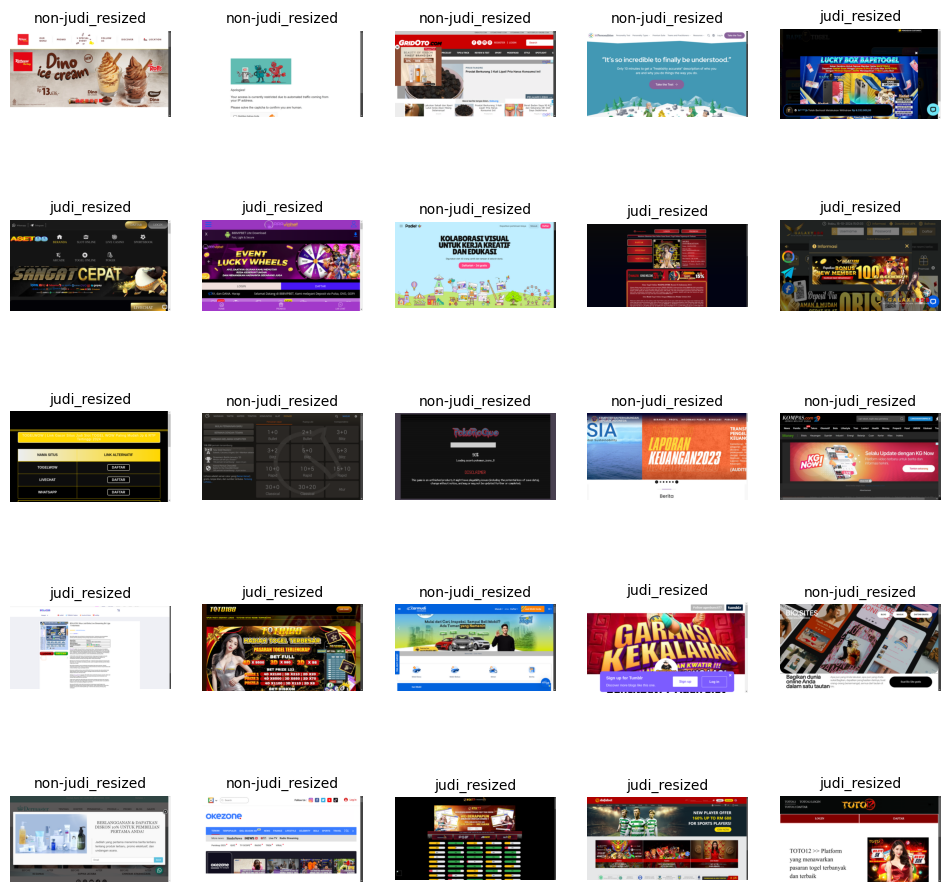

In [5]:
import matplotlib.gridspec as gridspec
rows = 5
cols = 5

selected_indices = random.sample(range(len(dataset)), rows * cols)

fig, axes = plt.subplots(rows, cols, figsize = (12, 12))
gs = gridspec.GridSpec(rows, cols, wspace = 0.0, hspace = 0.0)

for i, idx in enumerate(selected_indices):
    row = i // cols
    col = i % cols
    img_path = dataset['imgpath'].iloc[idx]
    label = dataset['labels'].iloc[idx]
    img = Image.open(img_path)
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    axes[row, col].set_title(label, fontsize = 10)

plt.show()

In [6]:
# Membagi dataset menjadi training, validation, dan testing
train_df, temp_df = train_test_split(dataset, train_size=0.8, stratify=dataset['labels'], random_state=42)
val_df, test_df = train_test_split(temp_df, train_size=0.5, stratify=temp_df['labels'], random_state=42)

# Hasil pembagian
print(f'\nTraining Dataframe of shape {train_df.shape}: \n{train_df.head()}')
print(f'\nValidation Dataframe of shape {val_df.shape}: \n{val_df.head()}')
print(f'\nTesting Dataframe of shape {test_df.shape}: \n{test_df.head()}')


Training Dataframe of shape (2055, 2): 
                                                imgpath            labels
1419  /kaggle/input/gamblingsitesid-img2/gamblingsit...  non-judi_resized
2542  /kaggle/input/gamblingsitesid-img2/gamblingsit...  non-judi_resized
2509  /kaggle/input/gamblingsitesid-img2/gamblingsit...  non-judi_resized
1163  /kaggle/input/gamblingsitesid-img2/gamblingsit...  non-judi_resized
2501  /kaggle/input/gamblingsitesid-img2/gamblingsit...  non-judi_resized

Validation Dataframe of shape (257, 2): 
                                                imgpath            labels
2101  /kaggle/input/gamblingsitesid-img2/gamblingsit...  non-judi_resized
565   /kaggle/input/gamblingsitesid-img2/gamblingsit...      judi_resized
2481  /kaggle/input/gamblingsitesid-img2/gamblingsit...  non-judi_resized
161   /kaggle/input/gamblingsitesid-img2/gamblingsit...      judi_resized
1852  /kaggle/input/gamblingsitesid-img2/gamblingsit...  non-judi_resized

Testing Dataframe of shape (

In [7]:
# Define the seed, batch size, and image size
seed = 42
batch_size = 16
img_size = (380, 380)

# Define the augmentation configuration with validation split
datagen = ImageDataGenerator(
    rescale=1./255,           # Normalisasi pixel (wajib)
    horizontal_flip=True,      # Bisa terjadi karena tangkapan layar bisa dibalik
    brightness_range=[0.8,1.2], # Variasi pencahayaan
)


# Apply the augmentation to the training data generator
train_data = datagen.flow_from_dataframe(
    train_df,
    x_col='imgpath',
    y_col='labels',
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size,
    target_size=img_size,
    shuffle=True,
    seed=seed
)

# For validation and test data, use a generator without augmentation but with rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)

val_data = validation_datagen.flow_from_dataframe(
    val_df,
    x_col='imgpath',
    y_col='labels',
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size,
    target_size=img_size,
    shuffle=False
)

test_data = validation_datagen.flow_from_dataframe(
    test_df,
    x_col='imgpath',
    y_col='labels',
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size,
    target_size=img_size,
    shuffle=False
)

Found 2055 validated image filenames belonging to 2 classes.
Found 257 validated image filenames belonging to 2 classes.
Found 257 validated image filenames belonging to 2 classes.


In [8]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications import EfficientNetB3

# Define the model with additional Dropout for regularization
base_model= EfficientNetB4(weights='imagenet', 
                         include_top=False, 
                         input_shape=(380, 380, 3))


for layer in base_model.layers[-20:]:
    layer.trainable = True

In [9]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Input(shape=img_size + (3,), name='input_layer'),
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3, seed=seed),
    Dense(1, activation='sigmoid', name='output_layer')
])

model.compile(optimizer = Adam(learning_rate = 0.0001), 
              loss = BinaryCrossentropy(), 
              metrics = ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)          │ (None, 12, 12, 1792)        │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         918,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,592,352 (70.92 MB)

 Trainable params: 18,467,145 (70.45 MB)

 Non-trainable params: 125,207 (489.09 KB)

In [10]:
# Callbacks
model_es = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, mode='min', patience=3, min_lr=0.00001)
model_checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Training
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[model_es, model_rlr, model_checkpoint]
)

Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 372s 1s/step - accuracy: 0.7874 - loss: 7.5781 - val_accuracy: 0.4047 - val_loss: 5.5827 - learning_rate: 1.0000e-04
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 76s 573ms/step - accuracy: 0.9595 - loss: 4.3194 - val_accuracy: 0.6459 - val_loss: 3.2642 - learning_rate: 1.0000e-04
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 76s 569ms/step - accuracy: 0.9840 - loss: 2.3760 - val_accuracy: 0.8132 - val_loss: 1.8502 - learning_rate: 1.0000e-04
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 76s 570ms/step - accuracy: 0.9844 - loss: 1.2538 - val_accuracy: 0.9144 - val_loss: 0.9459 - learning_rate: 1.0000e-04
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 75s 567ms/step - accuracy: 0.9949 - loss: 0.6291 - val_accuracy: 0.9416 - val_loss: 0.5282 - learning_rate: 1.0000e-04
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 76s 568ms/step - accuracy: 0.9921 - loss: 0.3147 - val_accuracy: 0.9494 - val_loss: 0.3096 - learning_rate: 1.0000e-04
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 76s 569m

In [11]:
test_results = model.evaluate(test_data, verbose=1)

print(f'Test Loss: {test_results[0]:.5f}')
print(f'Test Accuracy: {(test_results[1] * 100):.2f}%')

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.9502 - loss: 0.1727
Test Loss: 0.16927
Test Accuracy: 95.33%


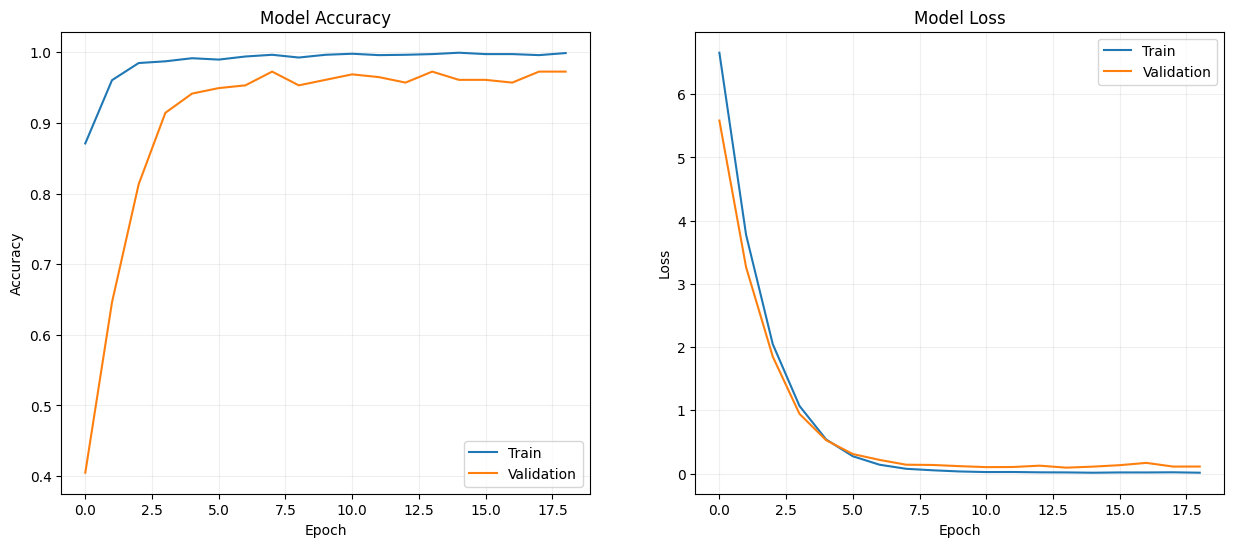

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))

# accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()